In [1]:
import sys
sys.path.insert(1,'../')

import numpy as np
from scipy import integrate
import scipy.constants as const
from scipy.optimize import minimize_scalar as minisc
from scipy import interpolate
import matplotlib.pyplot as plt
from tqdm.notebook import tnrange
import importlib

import SC
import kidcalc

In [ ]:
importlib.reload(kidcalc)
importlib.reload(SC)
s = SC.bTa()
points = 1000

for Tc in [1.0]:    
    s.kbTc = Tc*const.Boltzmann/const.e*1e6
    Ddata = np.zeros((3,points))
    kbTarr = np.logspace(np.log10(0.01),np.log10(.99),points)*s.kbTc
    for i in tnrange(len(kbTarr)):
        Ddata[0,i] = kbTarr[i]
        Ddata[1,i] = kidcalc.D(kbTarr[i],s)
        Ddata[2,i] = kidcalc.nqp(kbTarr[i],Ddata[1,i],s)
    Tcstr = str(np.around(
        s.kbTc/(const.Boltzmann/const.e*1e6),3
        )).replace('.','_')
    np.save(f'Ddata_{s.name}_{Tcstr}',Ddata)

  0%|          | 0/1000 [00:00<?, ?it/s]

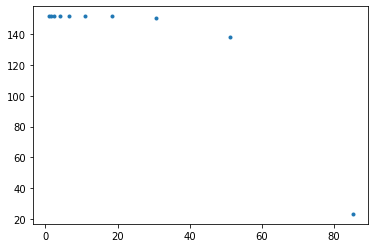

In [15]:
plt.plot(Ddata[0,:],Ddata[1,:],'.')

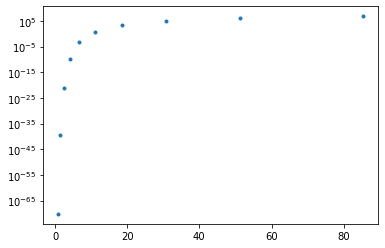

In [16]:
plt.plot(Ddata[0,:],Ddata[2,:], '.')
plt.yscale('log')